In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf
from PIL import Image
import imageio
import glob
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dense, BatchNormalization, LeakyReLU, Input, \
                         Reshape, MaxPooling2D, Flatten, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

import glob
from IPython import display

# Image import and preprocessing

In [3]:
folder='../input/anime-faces/data/'
filenames=os.listdir(folder)

In [4]:
filepaths=[folder+filename for filename in filenames if filename.find('png')!=-1]
print('find images:{}'.format(len(filepaths)))

find images:21551


In [5]:
def get_dataset(filepaths):
    images = []
    image_nums = len(filepaths)
    for i in tqdm(range(image_nums)):
        image = imageio.imread(filepaths[i])
        image = tf.cast(image,tf.float32)
        image = (image-127.5)/127.5
        images.append(image)
        #print('The image {} done'.format(i+1))
    #images=tf.data.Dataset.from_tensor_slices(images).shuffle(len(images)).batch(64)
    print('find {} images for trianing'.format(image_nums))
    return images

In [6]:
images = get_dataset(filepaths)

100%|██████████| 21551/21551 [01:19<00:00, 270.67it/s]

find 21551 images for trianing


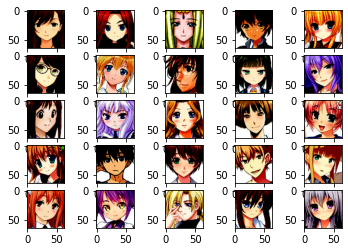

In [7]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.imshow(images[i])
plt.show()

In [8]:
len(images)

21551

In [9]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(len(images)).batch(batch_size)

# GAN Model

In [10]:
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(8*8*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8,8,256)))
  assert model.output_shape==(None,8,8,256)  #None is the batch size

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape==(None,8,8,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None,16,16,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
    
  model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2),use_bias=False, padding='same'))
  assert model.output_shape==(None,32,32,32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape==(None,64,64,3) 

  return model

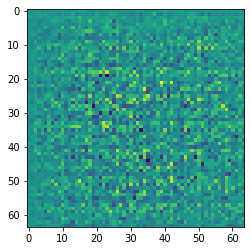

In [11]:
generator=make_generator_model()

noise=tf.random.normal([1,100]) #outputs a random value from normal distribution
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0,:,:,0])

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
def make_discrimator_model():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',
                                input_shape=[64,64,3]))
  
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [14]:
discriminator=make_discrimator_model()
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00166014]], shape=(1, 1), dtype=float32)


# Loss and Optimizer

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss

  return total_loss

In [17]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Saving Checkpoints

In [19]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,"ckpt")
checkpoint=tf.train.Checkpoint(generated_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                               discriminator=discriminator)

# Train

In [20]:
epochs=100
noise_dim=100
num_examples_to_generate=16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()

    for image_batch in dataset:
      train_step(image_batch)

    #Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch+1,
                             seed)
    
    #Save model every 15 seconds
    if(epoch+1)%15==0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                             epochs,
                             seed)

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

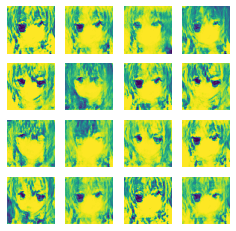

In [26]:
train(dataset, epochs)

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [30]:
# Display a single image using the epoch number
import PIL
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

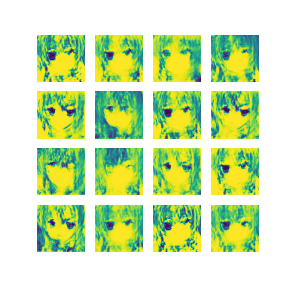

In [31]:
display_image(epochs)

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [33]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)